# Capstone 3: Preprocessing/Modeling

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [2]:
#load and check data
df = pd.read_csv('cleaned.csv')
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_salary,country,state,city,title_char,combined_text,total_word,total_sent,avg_words_sent
0,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,0,US,NY,NEW YORK,16,"Marketing Intern We're Food52, and we've creat...",383,7,54.714286
1,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,0,NZ,,AUCKLAND,41,Customer Service - Cloud Video Production 90 S...,901,25,36.040000
2,0,1,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,0,US,IA,WEVER,39,Commissioning Machinery Assistant (CMA) Valor ...,360,9,40.000000
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0,US,DC,WASHINGTON,33,Account Executive - Washington DC Our passion ...,709,9,78.777778
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,US,FL,FORT WORTH,19,Bill Review Manager SpotSource Solutions LLC i...,470,16,29.375000


In [3]:
#define target variable
y = df.fraudulent
X = df.drop('fraudulent', axis=1)

In [4]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

In [5]:
#define variable lists by type
numeric = X_train.select_dtypes(['int','float']).columns.tolist()
categorical = [column for column in X_train.columns if column not in numeric and column != 'combined_text']

In [6]:
#create pre-processor for variable types
processor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(strip_accents='unicode', stop_words='english'), 'combined_text'),
    ('number', MinMaxScaler(), numeric),
    ('category', OneHotEncoder(handle_unknown='ignore'), categorical)
])

In [7]:
#create model using imblearn pipeline for pre-processing, over-sampling, and the classifier
model = Pipeline(steps=[
    ['processor', processor],
    ['oversampling', SMOTE(random_state=14)],
    ['classifier', ComplementNB(alpha=0.2)]
])

In [8]:
#fit model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'combined_text'),
                                                 ('number', MinMaxScaler(),
                                                  ['telecommuting',
                                                   'has_company_logo',
                                                   'has_questions',
                                                   'has_salary', 'title_char',
                                                   'total_word', 'total_sent',
                                                   'avg_words_sent']),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),


In [9]:
#make predictions on both train and test sets
training_pred = model.predict(X_train)
testing_pred = model.predict(X_test)

In [10]:
#check accuracy score
training_accuracy = accuracy_score(y_train, training_pred)
testing_accuracy = accuracy_score(y_test, testing_pred)
print('training accuracy:')
print(training_accuracy)
print('testing accuracy:')
print(testing_accuracy)

training accuracy:
0.9782449874178099
testing accuracy:
0.9615530303030303


In [11]:
#check classification reports
training_report = classification_report(y_train, training_pred)
testing_report = classification_report(y_test, testing_pred)
print('training classification report:')
print(training_report)
print('testing classification report:')
print(testing_report)

training classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11732
           1       0.69      0.98      0.81       587

    accuracy                           0.98     12319
   macro avg       0.85      0.98      0.90     12319
weighted avg       0.98      0.98      0.98     12319

testing classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5011
           1       0.58      0.87      0.70       269

    accuracy                           0.96      5280
   macro avg       0.79      0.92      0.84      5280
weighted avg       0.97      0.96      0.97      5280



In [12]:
#check confusion matrices
training_matrix = confusion_matrix(y_train, training_pred)
testing_matrix = confusion_matrix(y_test, testing_pred)
print('training confusion matrix:')
print(training_matrix)
print('testing confusion matrix: ')
print(testing_matrix)

training confusion matrix:
[[11474   258]
 [   10   577]]
testing confusion matrix: 
[[4842  169]
 [  34  235]]


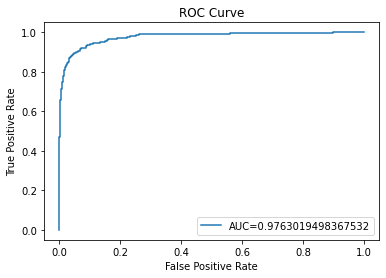

In [13]:
#plot AUC-ROC Curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

* Complement Naive Bayes was chosen as the classifier for its strong ability to deal with both imbalanced data and text data
* Model predictions were likely affected by categories/text not found in training data
* Model performance is strong for 'recall', the key metric for the business context (missing instances of fraud are more costly)
* Different parameters were tried that increased overall predictive performance (notably in precision) but at the cost of recall and were therefore rejected 